# Covid - 19. 
## Análise das séries temporais sobre a contaminação do vírus COVID-19 no Brasil.

### 1. Importando as bibliotecas que serão utilizadas

In [44]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima

### 2. Importando a base de dados

Dados extraídos do kaggle.

In [45]:
base_dados = pd.read_csv('covid_19_data.csv',
                        parse_dates = ['ObservationDate', 'Last Update'],
                        )

In [46]:
display(base_dados)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26708,26709,2020-05-19,Wyoming,US,2020-05-20 02:32:19,776.0,10.0,0.0
26709,26710,2020-05-19,Xinjiang,Mainland China,2020-05-20 02:32:19,76.0,3.0,73.0
26710,26711,2020-05-19,Yukon,Canada,2020-05-20 02:32:19,11.0,0.0,11.0
26711,26712,2020-05-19,Yunnan,Mainland China,2020-05-20 02:32:19,185.0,2.0,183.0


In [47]:
base_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26713 entries, 0 to 26712
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   SNo              26713 non-null  int64         
 1   ObservationDate  26713 non-null  datetime64[ns]
 2   Province/State   12882 non-null  object        
 3   Country/Region   26713 non-null  object        
 4   Last Update      26713 non-null  datetime64[ns]
 5   Confirmed        26713 non-null  float64       
 6   Deaths           26713 non-null  float64       
 7   Recovered        26713 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(2)
memory usage: 1.6+ MB


> Alterando alguns Nomes de colunas. 

In [48]:
base_dados.rename(columns = {'ObservationDate': 'observation_date',
                             'Province/State': 'province_state',
                             'Country/Region': 'country_region',
                             'Last Update': 'last_update',
                             'Confirmed': 'confirmed',
                             'Deaths': 'deaths',
                             'Recovered': 'recovered'
                            },
                  inplace = True)

display(base_dados.sample(4))

,SNo,observation_date,province_state,country_region,last_update,confirmed,deaths,recovered
17299,17300,2020-04-21,Michigan,US,2020-04-21 23:39:09,32667.0,2575.0,0.0
23027,23028,2020-05-09,Beijing,Mainland China,2020-05-10 02:32:30,593.0,9.0,565.0
13743,13744,2020-04-10,Grand Princess,US,2020-04-10 23:01:43,103.0,3.0,0.0
23943,23944,2020-05-12,NaN,Saint Vincent and the Grenadines,2020-05-13 03:32:26,17.0,0.0,12.0


### 3. Análises

Investigando as variáveis que estão disponíveis em relação aos casos confrimados no Brasil. 

In [49]:
Df_Brasil =  base_dados.loc[(base_dados.country_region == 'Brazil') & (base_dados.confirmed > 0)]
display(Df_Brasil)

,SNo,observation_date,province_state,country_region,last_update,confirmed,deaths,recovered
2455,2456,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
2903,2904,2020-03-01,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
24850,24851,2020-05-15,NaN,Brazil,2020-05-16 02:32:19,220291.0,14962.0,84970.0
25227,25228,2020-05-16,NaN,Brazil,2020-05-17 02:32:32,233511.0,15662.0,89672.0
25604,25605,2020-05-17,NaN,Brazil,2020-05-18 02:32:21,241080.0,16118.0,94122.0
25981,25982,2020-05-18,NaN,Brazil,2020-05-19 02:32:18,255368.0,16853.0,100459.0


In [50]:
Df_Brasil.province_state.unique() # Não tem dados sobre os estados

array([nan], dtype=object)

### Casos confirmados.

Vamos verificar como está o comportamento dos casos confirmados no Brasil 

In [51]:
px.line(Df_Brasil,
        x = 'observation_date',
        y = 'confirmed',
        labels = {'observation_date': 'Data',
                 'confirmed': 'Casos confirmados'},
        title = 'Casos confirmados no Brasil'
       )

### Novos casos por dia

In [52]:
# Função para realizar a contagem de novos acontecimentos por dia
# Nesse caso os acontecimentos são casos confirmados por dia

brasil_indice = Df_Brasil.reset_index()

def acontecimento_por_dia(lista, variavel):
    for x in np.arange(brasil_indice.shape[0]):
        if x == 0 :
            lista.append(0)
        else:
            lista.append(brasil_indice.loc[x, variavel] - brasil_indice.loc[x - 1, variavel])
    return lista


In [53]:
Df_Brasil['Novos_Casos_por_Dia'] = acontecimento_por_dia(lista = [], variavel = 'confirmed')

display(Df_Brasil)

C:\Users\Matrix\AppData\Local\Temp\ipykernel_2280\2812094385.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,SNo,observation_date,province_state,country_region,last_update,confirmed,deaths,recovered,Novos_Casos_por_Dia
2455,2456,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,1.0
2903,2904,2020-03-01,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
24850,24851,2020-05-15,NaN,Brazil,2020-05-16 02:32:19,220291.0,14962.0,84970.0,17126.0
25227,25228,2020-05-16,NaN,Brazil,2020-05-17 02:32:32,233511.0,15662.0,89672.0,13220.0
25604,25605,2020-05-17,NaN,Brazil,2020-05-18 02:32:21,241080.0,16118.0,94122.0,7569.0
25981,25982,2020-05-18,NaN,Brazil,2020-05-19 02:32:18,255368.0,16853.0,100459.0,14288.0


In [54]:
px.line(Df_Brasil,
        x = 'observation_date',
        y = 'Novos_Casos_por_Dia',
        labels = {'observation_date': 'Data',
                  'Novos_Casos_por_Dia': 'Novos Casos por dia'},
        title = 'Casos por dia'
       )

### Mortes

In [55]:
px.line(Df_Brasil,
        x = 'observation_date',
        y = 'deaths',
        labels = {'observation_date': 'Data',
                 'deaths': 'mortes'},
        title = 'Mortes confirmadas no Brasil' 
       )

In [56]:
Df_Brasil['Novas_Mortes_por_Dia'] = acontecimento_por_dia(lista = [], variavel = 'deaths');

display(Df_Brasil)

C:\Users\Matrix\AppData\Local\Temp\ipykernel_2280\449494335.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,SNo,observation_date,province_state,country_region,last_update,confirmed,deaths,recovered,Novos_Casos_por_Dia,Novas_Mortes_por_Dia
2455,2456,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0,0.0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0,0.0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0,0.0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,1.0,0.0
2903,2904,2020-03-01,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
24850,24851,2020-05-15,NaN,Brazil,2020-05-16 02:32:19,220291.0,14962.0,84970.0,17126.0,963.0
25227,25228,2020-05-16,NaN,Brazil,2020-05-17 02:32:32,233511.0,15662.0,89672.0,13220.0,700.0
25604,25605,2020-05-17,NaN,Brazil,2020-05-18 02:32:21,241080.0,16118.0,94122.0,7569.0,456.0
25981,25982,2020-05-18,NaN,Brazil,2020-05-19 02:32:18,255368.0,16853.0,100459.0,14288.0,735.0


In [57]:
px.line(Df_Brasil,
       x = 'observation_date',
       y = 'Novas_Mortes_por_Dia',
       labels = {'observation_date': 'Data',
                'Novas_Mortes_por_Dia': 'Novas mortes por dia'},
       title = 'Mortes por dia')

### Recuperados

In [58]:
px.line(Df_Brasil,
       x = 'observation_date',
       y = 'recovered',
       labels = {'observation_date': 'Data',
                'recovered': 'Recuperados'},
       title = 'Recuperados confirmados no Brasil')

In [59]:
Df_Brasil['Novos_Recuperados_por_Dia'] = acontecimento_por_dia(lista = [], variavel = 'recovered');

display(Df_Brasil);

C:\Users\Matrix\AppData\Local\Temp\ipykernel_2280\2089893981.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,SNo,observation_date,province_state,country_region,last_update,confirmed,deaths,recovered,Novos_Casos_por_Dia,Novas_Mortes_por_Dia,Novos_Recuperados_por_Dia
2455,2456,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0,0.0,0.0
2559,2560,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0,0.0,0.0
2668,2669,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0,0.0,0.0,0.0
2776,2777,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,1.0,0.0,0.0
2903,2904,2020-03-01,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
24850,24851,2020-05-15,NaN,Brazil,2020-05-16 02:32:19,220291.0,14962.0,84970.0,17126.0,963.0,5491.0
25227,25228,2020-05-16,NaN,Brazil,2020-05-17 02:32:32,233511.0,15662.0,89672.0,13220.0,700.0,4702.0
25604,25605,2020-05-17,NaN,Brazil,2020-05-18 02:32:21,241080.0,16118.0,94122.0,7569.0,456.0,4450.0
25981,25982,2020-05-18,NaN,Brazil,2020-05-19 02:32:18,255368.0,16853.0,100459.0,14288.0,735.0,6337.0


In [60]:
px.line(Df_Brasil,
       x = 'observation_date',
       y = 'Novos_Recuperados_por_Dia',
       labels = {'observation_date': 'Data',
                'Novos_Recuperados_por_Dia': 'Novos recuperados por dia'},
       title = 'Recuperados por dia')

## Predições

>### Novos casos

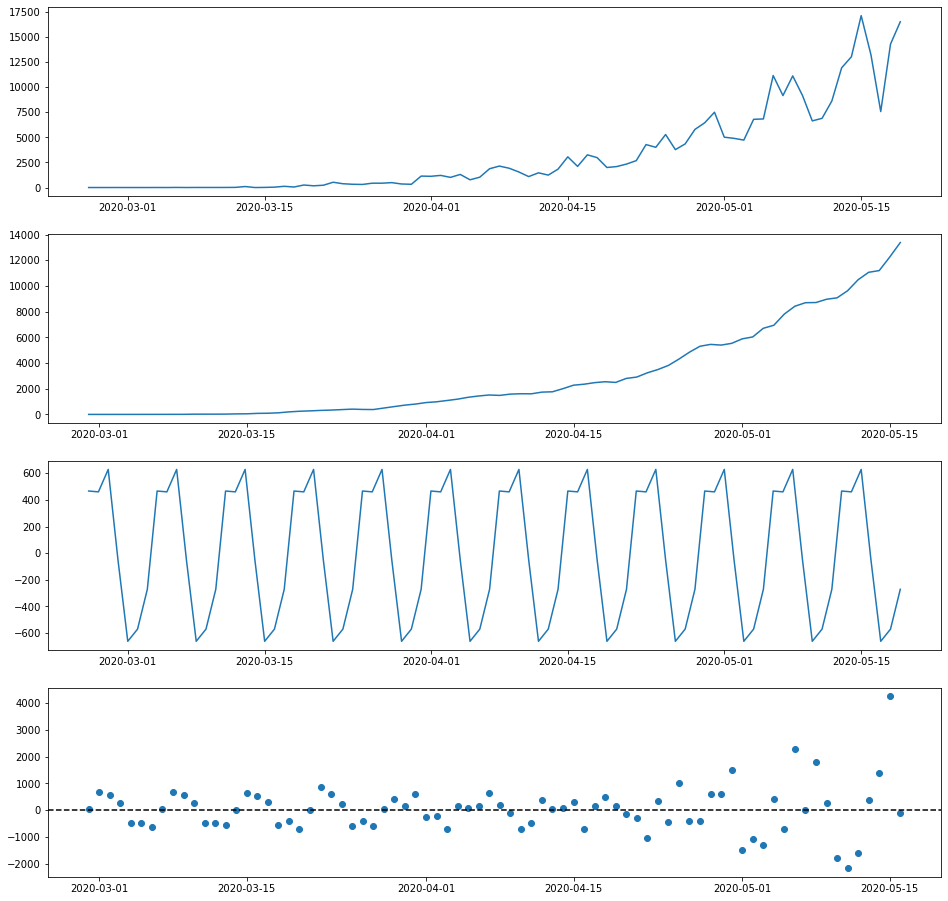

In [69]:
novoscasos = Df_Brasil.Novos_Casos_por_Dia
novoscasos.index = Df_Brasil.observation_date

resultado = seasonal_decompose(novoscasos) 

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(16,16))
ax1.plot(resultado.observed)    # observed: observados
ax2.plot(resultado.trend)       # trend: tendência  
ax3.plot(resultado.seasonal)    # seasonal: sazonalidade
ax4.scatter(novoscasos.index, resultado.resid) # plot do ruido com scatter
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

In [73]:
modelo1 = auto_arima(novoscasos)

fig = go.Figure(go.Scatter(x = novoscasos.index, 
                           y = novoscasos, 
                           name = 'Observed'
                          )
               )

fig.add_trace(go.Scatter(x = novoscasos.index, 
                         y = modelo1.predict_in_sample(), 
                         name = 'Predicted'
                        )
             )

fig.add_trace(go.Scatter(x = pd.date_range('2020-05-20', '2020-06-30'), 
                         y = modelo1.predict(41), 
                         name ='Forecast'
                        )
             )

fig.update_layout(title = 'Previsão de novos casos',
                  yaxis_title = 'Novos Casos', 
                  xaxis_title = 'Data'
                 )
fig.show()

> ### Mortes

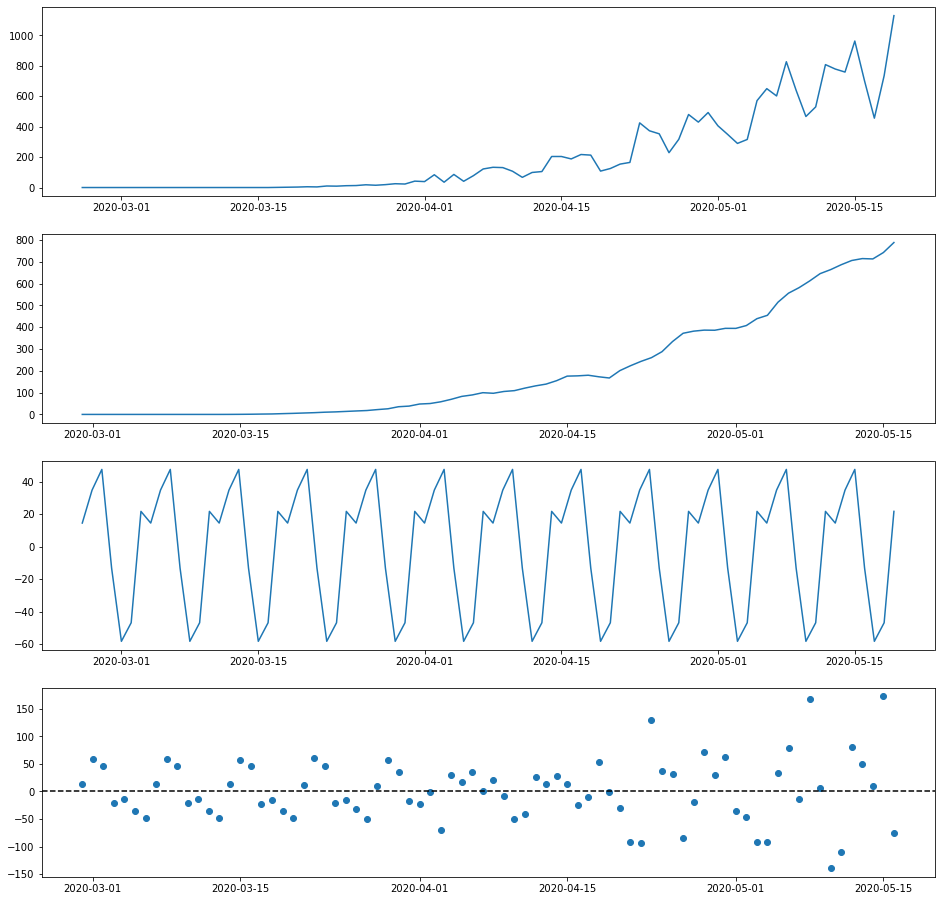

In [87]:
novasmortes = Df_Brasil.Novas_Mortes_por_Dia
novasmortes.index = Df_Brasil.observation_date

resultado2 = seasonal_decompose(novasmortes) 

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(16,16))
ax1.plot(resultado2.observed)    # observed: observados
ax2.plot(resultado2.trend)       # trend: tendência  
ax3.plot(resultado2.seasonal)    # seasonal: sazonalidade
ax4.scatter(novasmortes.index, resultado2.resid) # plot do ruido com scatter
ax4.axhline(0, 
            linestyle='dashed', 
            c='black')

plt.show()

In [88]:
modelo2 = auto_arima(novasmortes)

fig = go.Figure(go.Scatter(x = novasmortes.index, 
                           y = novasmortes, 
                           name = 'Observed'
                          )
               )

fig.add_trace(go.Scatter(x = novasmortes.index, 
                         y = modelo2.predict_in_sample(), 
                         name = 'Predicted'
                        )
             )

fig.add_trace(go.Scatter(x = pd.date_range('2020-05-20', '2020-06-30'), 
                         y = modelo2.predict(41), 
                         name ='Forecast'
                        )
             )

fig.update_layout(title = 'Previsão de novas mortes',
                  yaxis_title = 'Novas mortes', 
                  xaxis_title = 'Data'
                 )
fig.show()

> ### Recuperados

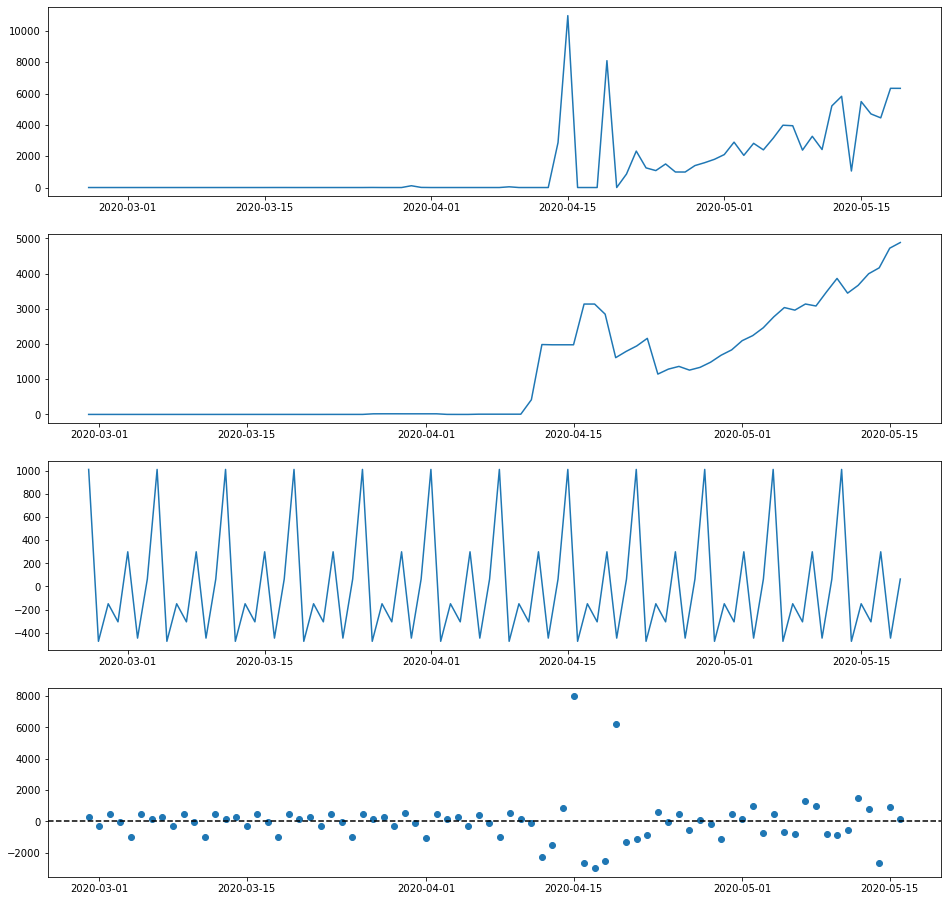

In [89]:
novosrecuperados = Df_Brasil.Novos_Recuperados_por_Dia
novosrecuperados.index = Df_Brasil.observation_date

resultado3 = seasonal_decompose(novosrecuperados) 

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(16,16))
ax1.plot(resultado3.observed)    # observed: observados
ax2.plot(resultado3.trend)       # trend: tendência  
ax3.plot(resultado3.seasonal)    # seasonal: sazonalidade
ax4.scatter(novosrecuperados.index, resultado3.resid) # plot do ruido com scatter
ax4.axhline(0, 
            linestyle='dashed', 
            c='black')
plt.show()

In [90]:
modelo3 = auto_arima(novosrecuperados)

fig = go.Figure(go.Scatter(x = novosrecuperados.index, 
                           y = novosrecuperados, 
                           name = 'Observed'
                          )
               )

fig.add_trace(go.Scatter(x = novosrecuperados.index, 
                         y = modelo3.predict_in_sample(), 
                         name = 'Predicted'
                        )
             )

fig.add_trace(go.Scatter(x = pd.date_range('2020-05-20', '2020-06-30'), 
                         y = modelo3.predict(41), 
                         name ='Forecast'
                        )
             )

fig.update_layout(title = 'Previsão de recuperados',
                  yaxis_title = 'Novos recuperados', 
                  xaxis_title = 'Data'
                 )
fig.show()